In [3]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu
import statsmodels.stats.multitest

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

# Load in the data and filter to Pearson correlation

In [5]:
data_path = "/Users/abry4213/data/HCP100/"

# Load in all the pyspi homotopic res
all_homotopic_res = pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*.csv")])
pearson_homotopic_res = all_homotopic_res.query("SPI=='cov_EmpiricalCovariance' & base_region_from == base_region_to")
di_gaussian_homotopic_res = all_homotopic_res.query("SPI=='di_gaussian' & base_region_from == base_region_to")

# Compute the mean value for each base_region_to in pearson_homotopic_res
pearson_homotopic_res_mean = (pearson_homotopic_res
                                  .groupby(['Subject', 'base_region_to', 'SPI'])['value'].mean().reset_index()
                                  .groupby("base_region_to")['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"base_region_to": "Base_Region",
                                                   "value": "Mean_Pearson_R"}))

pearson_homotopic_res_for_dk = (pearson_homotopic_res
                                  .groupby(["base_region_to", 'hemi_from'])['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"value": "Mean_Pearson_R"})
                                    )

## Visualize the mean Pearson FC from L--R and R--L in the brain (averaged across hemispheres, first)

In [6]:
# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

# Read in the DK atlas
lh_labels, lh_ctab, lh_names = fs.read_annot(lh_dk)
rh_labels, rh_ctab, rh_names = fs.read_annot(rh_dk)

# Some big endian byte-swapping is needed
lh_labels = lh_labels.byteswap().view(lh_labels.dtype.newbyteorder('='))
rh_labels = rh_labels.byteswap().view(rh_labels.dtype.newbyteorder('='))

# Create a lookup table dataframe
lh_names_df = pd.DataFrame({'Region': lh_names, 'Vertex_Value': range(len(lh_names))}).assign(Region = lambda x: x['Region'].str.decode('utf-8'))
rh_names_df = pd.DataFrame({'Region': rh_names, 'Vertex_Value': range(len(rh_names))}).assign(Region = lambda x: x['Region'].str.decode('utf-8'))

# Convert vertices to a DataFrame
lh_labels_df = pd.DataFrame({'Vertex_Value': lh_labels, 'Vertex_Index': range(len(lh_labels))}).merge(lh_names_df, on='Vertex_Value', how='left')
rh_labels_df = pd.DataFrame({'Vertex_Value': rh_labels, 'Vertex_Index': range(len(rh_labels))}).merge(rh_names_df, on='Vertex_Value', how='left')

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


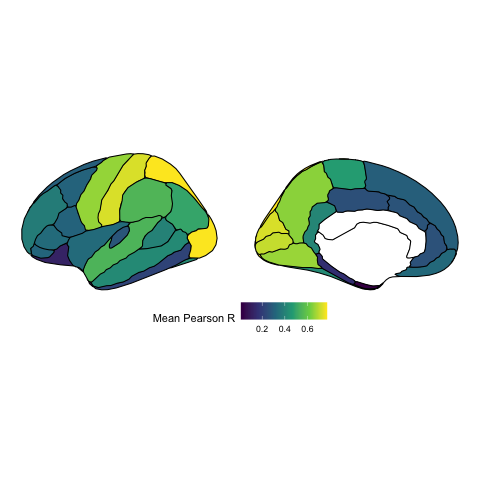

In [7]:
%%R -i pearson_homotopic_res_mean

### Pearson FC in brain ###
pearson_homotopic_res_mean %>%
  ungroup() %>%
  mutate(label = glue("lh_{Base_Region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = Mean_Pearson_R),
        position = "stacked", colour = "black", hemisphere="left",
        linewidth=0.5) +
  theme_void() +
  labs(fill = "Mean Pearson R") +
  theme(plot.title = element_blank(),
        legend.position = "bottom") +
  scale_fill_viridis_c(na.value = "white")
# ggsave("../plots/measure_maps/Mean_LR_averaged_Pearson_R_ggseg.svg", width = 4, height = 3)

## Is the magnitude of homotopic Pearson FC across brain regions tied to (1) Euclidean distance between the two regions and/or (2) the number of streamlines between those two regions on average?

### Calculate Euclidean, geodesic, and fiber connectivity distances between each region--region pair

In [11]:
# Read in brain region lookup table
brain_region_info = pd.read_csv("../data/Brain_Region_Info.csv")
fsaverage_data_base_path = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage"

all_centroid_res_list = []
for hemi in ["lh", "rh"]:

    # Load annotation file (parcellation)
    annot_path = f"{fsaverage_data_base_path}/{hemi}.aparc.annot"
    labels, ctab, names = fs.read_annot(annot_path)

    # Load label file (vertex coordinates)
    label_path = f"{fsaverage_data_base_path}/{hemi}.aparc.label"
    vertices = fs.read_label(label_path)

    # Load the FreeSurfer surface (to get vertex coordinates)
    pial_path = f"{fsaverage_data_base_path}/{hemi}.pial"
    surf = fs.read_geometry(pial_path)
    coords, faces = surf
    cort = np.sort(fs.read_label(f"{fsaverage_data_base_path}/{hemi}.cortex.label"))

    # Create a dictionary to store centroids
    roi_centroids = {}

    # Compute centroids for each ROI
    for i, roi_name in enumerate(names):
        roi_vertices = np.where(labels == i)[0]  # Get vertex indices in this ROI
        if len(roi_vertices) > 0:
            roi_centroids[roi_name] = coords[roi_vertices].mean(axis=0)  # Mean position

    # Convert centroids to DataFrame
    centroid_df = pd.DataFrame(roi_centroids).T
    centroid_df.columns = ["x", "y", "z"]

    # Convert names to strings, dropping corpuscallosum
    names_dec = [name.decode() for name in names if name.decode() not in ["corpuscallosum"]]

    # If centroid_df has 34 rows, drop 'unknown' from names
    if centroid_df.shape[0] == 34:
        names_dec = [name for name in names_dec if name != "unknown"]

    # Add region names and hemisphere
    centroid_df = (centroid_df.reset_index(drop=True).assign(Base_Region=names_dec, 
                                                             Hemisphere=np.where(hemi == "lh", "Left", "Right"))
                                                     .assign(Brain_Region = lambda x: hemi + '-' + x['Base_Region']))

    # Append to list
    all_centroid_res_list.append(centroid_df)

# Concatenate the results
all_centroid_res = pd.concat(all_centroid_res_list).query("Base_Region != 'unknown'")

# Compute Euclidean distances between all ROI centroids
dist_matrix = cdist(all_centroid_res[['x', 'y', 'z']], all_centroid_res[['x', 'y', 'z']], metric="euclidean")

# Convert to DataFrame
euclidean_dist_df = (pd.DataFrame(dist_matrix, index=all_centroid_res['Brain_Region'], 
                        columns=all_centroid_res['Brain_Region'])
                        .reset_index()
                        .rename(columns={"Brain_Region": "Brain_Region_From"})
                        .melt(id_vars='Brain_Region_From', var_name='Brain_Region_To', value_name='Euclidean_Distance')
                        .query("Brain_Region_From != Brain_Region_To")
                        .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.split('-').str[1],
                                Base_Region_To = lambda x: x['Brain_Region_To'].str.split('-').str[1],
                                Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.split('-').str[0]=='lh', 'Left', 'Right'),
                                Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.split('-').str[0]=='lh', 'Left', 'Right'))
                        )

# Filter to just the homotopic regions
homotopic_euclidean_dist_df = (euclidean_dist_df.query("Base_Region_From == Base_Region_To").drop_duplicates(subset=['Base_Region_To', 'Euclidean_Distance'])
                               .filter(['Base_Region_To', 'Euclidean_Distance'])
                               .rename(columns={"Base_Region_To": "Base_Region",
                                                "Euclidean_Distance": "Value"})
                               .assign(Category = "Microstructure", Description = "Euclidean Distance")
                               )

# Load in the group-averaged connectome data
homotopic_SC_dist_df = (pd.read_csv(f"{data_path}/raw_data/diffusion_MRI/aparc_HCP100_group_avg_SIFT2_mean.csv",
                               header=None, 
                               names=brain_region_info.Brain_Region)
                               .assign(Brain_Region_From=brain_region_info.Brain_Region)
                               .melt(id_vars="Brain_Region_From", var_name="Brain_Region_To", value_name="SC")
                               .assign(log_SC = lambda x: np.where(x['SC'] > 0, np.log(x['SC']), 0))
                               .query("Brain_Region_From != Brain_Region_To")
                               .assign(Base_Region_From = lambda x: x.Brain_Region_From.str.replace('ctx-lh-', ''),
                                       Base_Region_To = lambda x: x.Brain_Region_To.str.replace('ctx-lh-', ''),
                                       Hemi_From = lambda x: np.where(x.Brain_Region_From.str.contains('lh'), 'Left', 'Right'),
                                       Hemi_To = lambda x: np.where(x.Brain_Region_To.str.contains('lh'), 'Left', 'Right'))
                                .assign(Base_Region_From = lambda x: x.Base_Region_From.str.replace('ctx-rh-', ''),
                                        Base_Region_To = lambda x: x.Base_Region_To.str.replace('ctx-rh-', ''))
                               .query("Base_Region_From == Base_Region_To")
                               .rename(columns={"Base_Region_From": "Base_Region"})
                               .drop_duplicates(subset=['Base_Region', 'SC', 'log_SC'])
                               .filter(['Base_Region', 'log_SC'])
                               .rename(columns={"log_SC": "Value"})
                               .assign(Category = "Microstructure", Description = "Log-SC")
)

# Merge the results
structural_data = (pd.concat([homotopic_euclidean_dist_df, homotopic_SC_dist_df])
                           .merge(pearson_homotopic_res_mean, on="Base_Region", how="left"))

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
%%R -i structural_data

structural_data %>% 
    filter(Description %in% c("Euclidean Distance", "Log-SC")) %>%
    ggplot(aes(x=Value, y=Mean_Pearson_R, fill=Mean_Pearson_R)) +
    geom_point(color='black', shape=21, size=3) +
    scale_fill_viridis_c() +
    geom_smooth(method="lm", se=FALSE, color='black') +
    facet_wrap(. ~ Description, scales="free", ncol=1) +
    theme(legend.position="none") +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
    xlab("Value") +
    ylab("Mean Pearson R") +
    theme(strip.background = element_blank(),
          strip.text = element_text(face='bold', size=14))

# ggsave("../plots/measure_maps/Mean_Pearson_R_magnitude_vs_physical_distance.svg", width=2.7, height=5, dpi=300, units="in")

### Plot the SC/Euclidean distance per region in the brain

Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


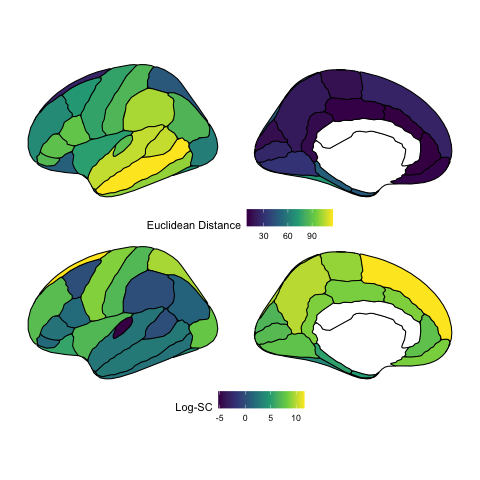

In [13]:
%%R -i structural_data

all_ggseg_plots_list <- list()

for (desc in unique(structural_data$Description)) {
      desc_p <- structural_data %>%
            filter(Description==desc) %>% 
            mutate(label = glue("lh_{Base_Region}")) %>%
            left_join(., as_tibble(dk)) %>%
            ggseg(atlas = dk, mapping = aes(fill = Value),
                  position = "stacked", colour = "black", hemisphere="left",
                  linewidth=0.5) +
            theme_void() +
            labs(fill = desc) +
            theme(plot.title = element_blank(),
                  legend.position = "bottom") +
            scale_fill_viridis_c(na.value = "white")

      all_ggseg_plots_list[[desc]] <- desc_p
}

wrap_plots(all_ggseg_plots_list, ncol=1)
# ggsave("../plots/measure_maps/structural_data_ggseg_res.svg", width=4, height=4, dpi=300, units="in")


## Is mean homotopic FC correlated with region volume?

In [20]:
# Load in regional volumes
regional_volumes = pd.read_csv(f"{data_path}/raw_data/structural_MRI/HCP100_all_dk_volumes.csv")
regional_volumes_mean = (regional_volumes
                         .groupby('Region')['Volume']
                         .mean()
                         .reset_index()
                         .rename(columns={"Region": "Region_Index", "Volume": "Mean_Volume"})
                         .assign(Region_Index = lambda x: x.Region_Index.astype(int))
                         .merge(brain_region_info, on="Region_Index", how="left")
)

regional_volumes_mean_hemi_avg = (regional_volumes_mean
                                    .groupby('Base_Region')['Mean_Volume']
                                    .mean()
                                    .reset_index()
                                    .merge(pearson_homotopic_res_mean, on="Base_Region", how="left")
    )


# Fit a Spearman correlation
volume_pearson_corr = spearmanr(regional_volumes_mean_hemi_avg['Mean_Volume'], regional_volumes_mean_hemi_avg['Mean_Pearson_R'])
volume_pearson_corr

SignificanceResult(statistic=0.041100076394194045, pvalue=0.8174811393375013)

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 



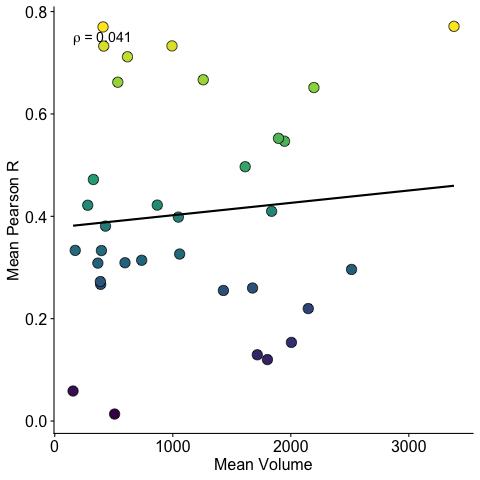

In [21]:
%%R -i regional_volumes_mean_hemi_avg

regional_volumes_mean_hemi_avg %>%
    ggplot(aes(x=Mean_Volume, y=Mean_Pearson_R, fill=Mean_Pearson_R)) +
    geom_point(color='black', shape=21, size=4.5) +
    scale_fill_viridis_c() +
    geom_smooth(method="lm", se=FALSE, color='black') +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
    xlab("Mean Volume") +
    ylab("Mean Pearson R") +
    theme(legend.position="none",
          axis.text = element_text(size=16),
          axis.title = element_text(size=16))
# ggsave("../plots/measure_maps/Mean_Pearson_R_magnitude_vs_volume.svg", width=3.5, height=3.2, dpi=300, units="in")


Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


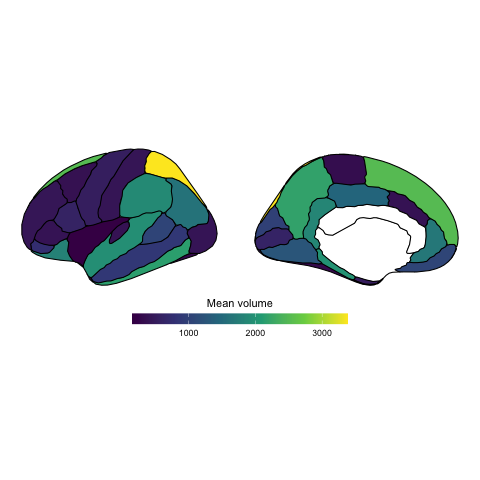

In [22]:
%%R -i regional_volumes_mean_hemi_avg

regional_volumes_mean_hemi_avg %>%
      mutate(label = glue("lh_{Base_Region}")) %>%
      left_join(., as_tibble(dk)) %>%
      ggseg(atlas = dk, mapping = aes(fill = Mean_Volume),
            position = "stacked", colour = "black", hemisphere="left",
            linewidth=0.5) +
      theme_void() +
      labs(fill = "Mean volume") +
      theme(plot.title = element_blank(),
            legend.key.width  = unit(3, "lines"),
            legend.key.height  = unit(0.75, "lines"),
            legend.position = "bottom") +
      scale_fill_viridis_c(na.value = "white") +
      guides(fill = guide_colorbar(title.position="top", title.hjust=0.5))

# ggsave("../plots/measure_maps/Mean_Pearson_R_magnitude_vs_volume_ggseg.svg", width=4, height=2, dpi=300, units="in")
